In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

from load_data import create_graph, read_and_normalize_property_data, z_score_normalize
from utils import (random_graph_sequence, plot_function, remove_undirected_edges, 
                   resample_curve, get_curve_from_graph, plot_curve, get_highDim_curve,
                   get_resampled_geostats_curve)
from metrics import get_SRVMetric_distance, get_L2_norm_two_curves, get_SRVMetric_aligned_distance, get_dtw_distance

INFO: Using numpy backend


## Load data

In [2]:
stone_ids = ['BT.1.4-25.','BT.1.A.','BT.1.C.','BT.1.F.','BT.2.65.','BT.2.UUU.', 
              'T-1_A_R', 'T-1_18_R', 'T-1_19_R', 'T-1_47_R', 'T-1_57_R']
#filename = 'Melton_sequence_data_sample.xlsx'
filename = 'sequence_data_1-22-2024.xlsx'
k_sampling_points = 40

dataset = pd.read_excel(filename, sheet_name='Sample_data')
data_collection = read_and_normalize_property_data(dataset, stone_ids)

graphs = {}
for stone_id in stone_ids:
    G = create_graph(dataset, data_collection, stone_id)
    graphs[stone_id] = G

In [ ]:
def diffeomorphism(self, base_point):
    r"""Square Root Velocity Transform (SRVT).

    Compute the square root velocity representation of a curve. The
    velocity is computed using the log map.

    In the case of several curves, an index selection procedure allows to
    get rid of the log between the end point of curve[k, :, :] and the starting
    point of curve[k + 1, :, :].

    .. math::
        Q(c) = c'/ |c'|^{1/2}

    Parameters
    ----------
    base_point : array-like, shape=[..., k_sampling_points - 1, ambient_dim]
        Discrete curve.

    Returns
    -------
    image_point : array-like, shape=[..., k_sampling_points - 1, ambient_dim]
        SRV representation.
    """
    ndim = self._point_ndim
    base_point_with_origin = insert_zeros(base_point, axis=-ndim)

    velocity = forward_difference(base_point_with_origin, axis=-ndim)

    pointwise_velocity_norm = self.ambient_manifold.metric.norm(
        velocity, base_point_with_origin[..., :-1, :]
    )
    return gs.einsum(
        "...ij,...i->...ij", velocity, 1.0 / gs.sqrt(pointwise_velocity_norm)
    )
    
def forward_difference(array, delta=None, axis=-1):
    """Forward difference in a Euclidean space.

    Points live in R^n, but are a 1d embedding (e.g. a curve).

    Parameters
    ----------
    array : array-like
        Values of a function.
    delta : float
        Spacing between points.
    axis : int
        Axis in which perform the difference.
        Must be given backwards.

    Returns
    -------
    forward_diff : array-like
        Shape in the specified axis reduces by one.
    """
    n = array.shape[axis]
    if delta is None:
        delta = 1 / (n - 1)

    none_slc = (slice(None),) * (abs(axis) - 1)

    slc = (..., slice(1, n)) + none_slc
    forward = array[slc]

    slc = (..., slice(0, n - 1)) + none_slc
    center = array[slc]
    return (forward - center) / delta

## Create Distance matrices

In [4]:
srv_matrix = np.zeros((len(stone_ids),len(stone_ids)))
srv_matrix[:] = np.nan
l2_matrix = np.zeros((len(stone_ids),len(stone_ids)))
l2_matrix[:] = np.nan
align_matrix = np.zeros((len(stone_ids),len(stone_ids)))
align_matrix[:] = np.nan
dtw_matrix = np.zeros((len(stone_ids),len(stone_ids)))
dtw_matrix[:] = np.nan

for s in range(50):
    store_curves = {}
    for id in stone_ids:
        curve_hd = get_highDim_curve(id, graphs, k_sampling_points)
        store_curves[id] = curve_hd

    for i, id1 in enumerate(stone_ids):
        for j, id2 in enumerate(stone_ids):
            dist_hd = get_SRVMetric_distance(store_curves[id1], store_curves[id2], k_sampling_points)
            dist_dtw = get_dtw_distance(store_curves[id1], store_curves[id2])
            distL2 = get_L2_norm_two_curves(store_curves[id1].T[1:],store_curves[id2].T[1:])
            
            # try:
            #     dist_geod_aligned = get_SRVMetric_aligned_distance(store_curves[id1], store_curves[id2], k_sampling_points)
            #     align_matrix[i,j] = np.nanmin([dist_geod_aligned, align_matrix[i,j]])
            # except:
            #     align_matrix[i,j] = np.nanmin([np.nan, align_matrix[i,j]])
                
            srv_matrix[i,j] = np.nanmin([dist_hd, srv_matrix[i,j]])
            l2_matrix[i,j] = np.nanmin([distL2, l2_matrix[i,j]])
            dtw_matrix[i,j] = np.nanmin([dist_dtw, dtw_matrix[i,j]])

In [5]:
print(dtw_matrix)

[[ 0.         10.46553792 11.95595945  7.18023338 10.08702322 13.57542506
   8.25325493  5.95168728 11.88331441 12.0988897  10.16324457]
 [10.46553792  0.          8.58972745  7.83110151  6.07974028  6.96154557
   6.21680885  7.77410601 10.51486289  9.99393391  8.60622383]
 [11.95595945  8.58972745  0.          8.36925749  7.55177748  8.0772002
   9.24455086 10.0797253  11.0485982  10.50163077 10.25485558]
 [ 7.18023338  7.83110151  8.36925749  0.          6.53076006  9.78207351
   6.75657407  5.60514564 10.18741381 10.65683313  8.42194372]
 [10.08702322  6.07974028  7.55177748  6.53076006  0.          9.38008294
   6.58768668  7.03831152 10.19249193 10.10930454  8.4601983 ]
 [13.57542506  6.96154557  8.0772002   9.78207351  9.38008294  0.
  11.08132402  9.71882863 12.12952057 12.2222435  11.68205501]
 [ 8.25325493  6.21680885  9.24455086  6.75657407  6.58768668 11.08132402
   0.          5.41129655 10.25001352  9.79505387  7.80640761]
 [ 5.95168728  7.77410601 10.0797253   5.60514564 

In [6]:
print(np.around(align_matrix,4))

[[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]]


In [7]:
print(srv_matrix)

[[0.         5.90639211 5.6459298  5.01798088 4.55809742 5.28031119
  5.54498781 4.45368339 7.13401791 4.61290734 4.90343915]
 [5.90639211 0.         6.53229121 6.66600277 6.6299272  6.36770123
  6.6492324  6.36891584 8.44246341 6.78082751 6.5862974 ]
 [5.6459298  6.53229121 0.         5.61055407 5.85041623 5.71719512
  6.56842019 5.59345275 7.80945455 5.87768757 6.05406253]
 [5.01798088 6.66600277 5.61055407 0.         6.02834186 6.10015207
  6.61666769 5.19309952 7.43284766 5.78722924 6.24735966]
 [4.55809742 6.6299272  5.85041623 6.02834186 0.         6.54277579
  5.83864403 4.85949587 7.75405496 5.68044847 6.12560945]
 [5.28031119 6.36770123 5.71719512 6.10015207 6.54277579 0.
  6.54673229 5.70458541 8.37123414 6.01769565 5.49998159]
 [5.54498781 6.6492324  6.56842019 6.61666769 5.83864403 6.54673229
  0.         5.63108401 8.29269416 6.29083409 6.08313566]
 [4.45368339 6.36891584 5.59345275 5.19309952 4.85949587 5.70458541
  5.63108401 0.         7.47460228 5.36493214 5.31689897]


In [8]:
print(l2_matrix)

[[ 0.         11.68823575 13.52666931  8.72966457 12.40900606 13.94021899
   9.91447194  7.29625045 12.61559524 12.28402698 11.36206531]
 [11.68823575  0.         10.73526006  9.70070748  7.20044516  9.70091723
   8.01618762  8.89672116 11.88475183 11.52506794 10.04519853]
 [13.52666931 10.73526006  0.         10.84275777 10.95816521 11.03227473
  10.6786165  12.05345589 12.88202787 11.55953545 11.9979516 ]
 [ 8.72966457  9.70070748 10.84275777  0.         11.80300063 11.35539761
   8.14971544  7.50289854 11.6404228  11.12637622 10.32084447]
 [12.40900606  7.20044516 10.95816521 11.80300063  0.         12.14775272
  10.06245007  9.48211125 11.80783744 13.33207324 11.41485498]
 [13.94021899  9.70091723 11.03227473 11.35539761 12.14775272  0.
  12.49089527 11.55527259 14.28390695 12.81373742 12.7297551 ]
 [ 9.91447194  8.01618762 10.6786165   8.14971544 10.06245007 12.49089527
   0.          6.58417809 11.18325975 10.56259202  8.69705398]
 [ 7.29625045  8.89672116 12.05345589  7.50289854

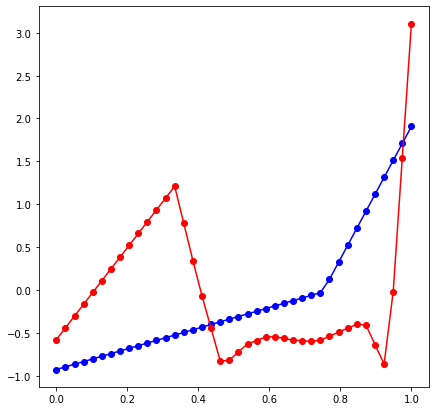

In [18]:
node_id1 = 'BT.1.4-25.'
node_id2 = 'BT.2.65.'

curve_a = get_resampled_geostats_curve(node_id1, graphs, "volume", k_sampling_points)
curve_b = get_resampled_geostats_curve(node_id2, graphs, "volume", k_sampling_points)

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
#lt.axis("equal")
plt.show()

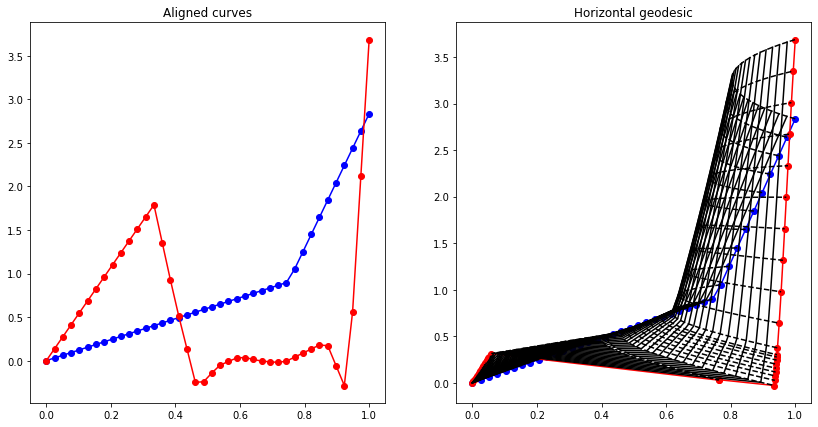

In [19]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)
curve_a = curves_r2.projection(curve_a)
curve_b = curves_r2.projection(curve_b)

curves_r2.equip_with_metric(SRVMetric) #
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

curve_b_aligned = curves_r2.fiber_bundle.align(curve_b, curve_a)

hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b)

n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
hgeod = hgeod_fun(times)

def plot_geodesic(geod, translation=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "o-r")

    for i in range(1, n_times - 1):
        ax.plot(geod[i, :, 0], geod[i, :, 1], "k")

    for j in range(k_sampling_points):
        ax.plot(geod[:, j, 0], geod[:, j, 1], "--k")

    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_curve(curve_a, "o-b", ax=ax1)
plot_curve(curve_b, "o-r", ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

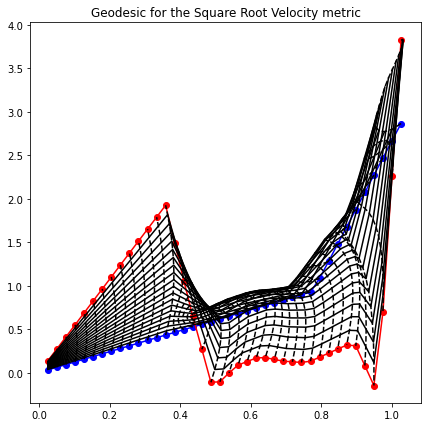

In [20]:
curves_r2.equip_with_metric(SRVMetric)
geod_fun = curves_r2.metric.geodesic(curve_a, curve_b)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)
translation = gs.linspace(curve_a[0], curve_b[0], n_times)

plot_geodesic(geod, translation)
plt.title("Geodesic when both curves are reparametrized in the same way")
plt.show()

In [14]:
####### Plot Graph #######
# plt.figure(figsize=(16,16))
# nx.draw(graphs['BT.1.A.'], pos=nx.kamada_kawai_layout(graphs['BT.1.A.']), with_labels=True, font_weight='bold')
# plt.show()

## Plot time series functions

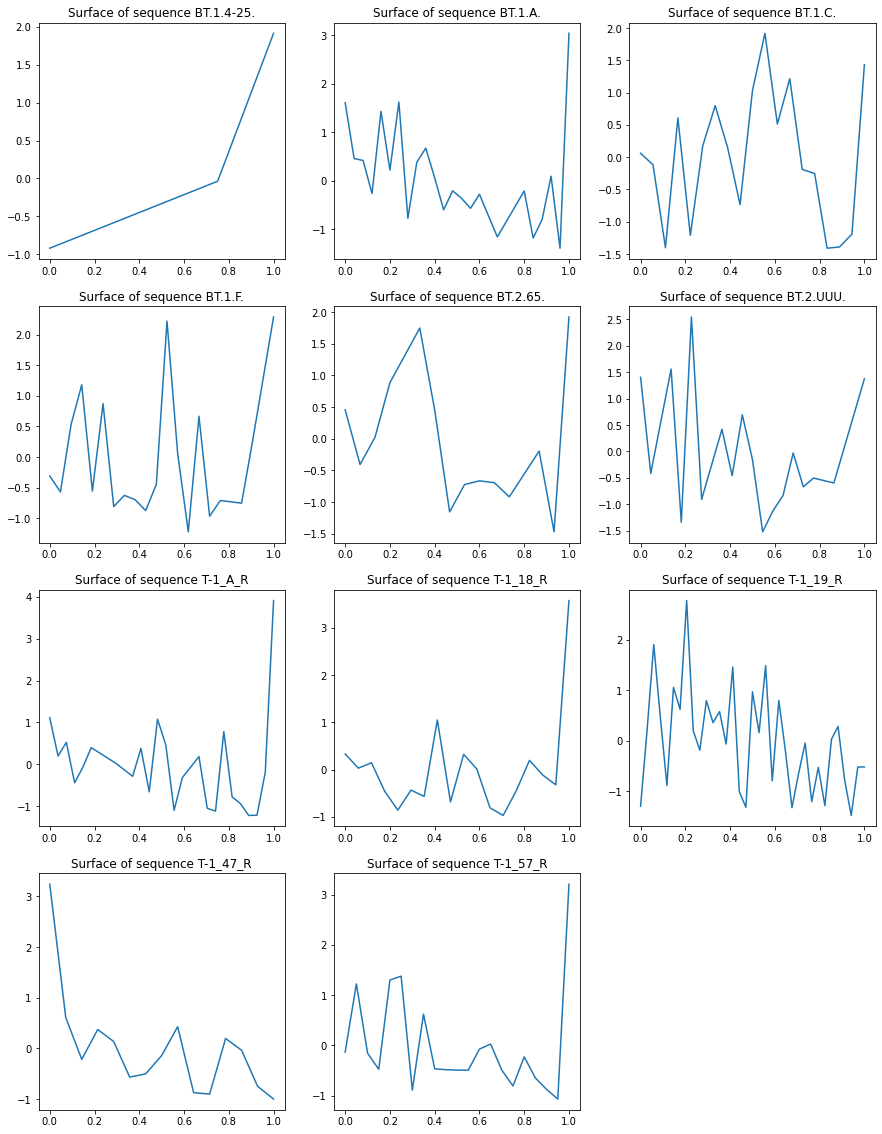

In [13]:
store_node_lists = {}
for id in stone_ids:
    nodes_list = random_graph_sequence(graphs[id])
    store_node_lists[id] = nodes_list
    
fig = plt.figure(figsize=(15, 20))
for index, (id, nodes_list) in enumerate(store_node_lists.items()):
    plt.subplot(4,3, index+1)
    plot_function(nodes_list, graphs, id, "surface")
    plt.title("Surface of sequence "+id)
plt.show()

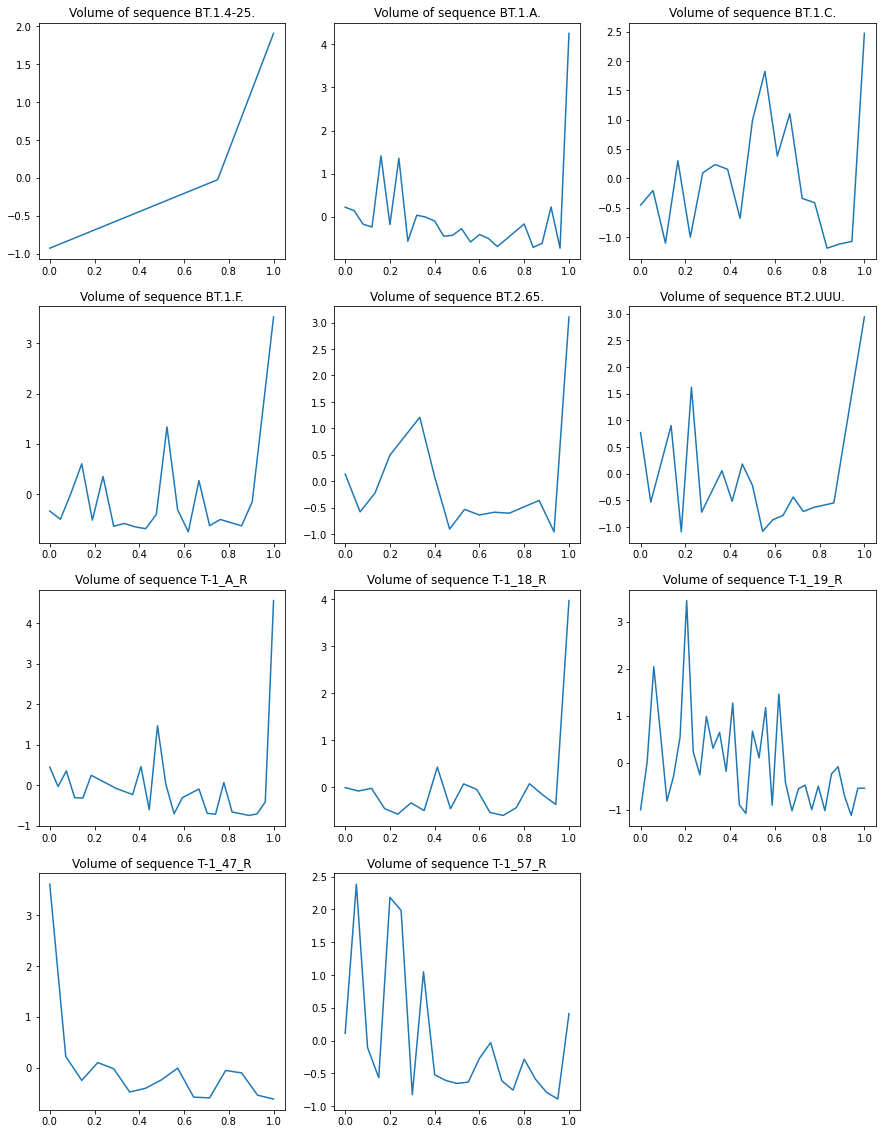

In [14]:
fig = plt.figure(figsize=(15, 20))
for index, (id, nodes_list) in enumerate(store_node_lists.items()):
    plt.subplot(4,3, index+1)
    plot_function(nodes_list, graphs, id, "volume")
    plt.title("Volume of sequence "+id)
plt.show()

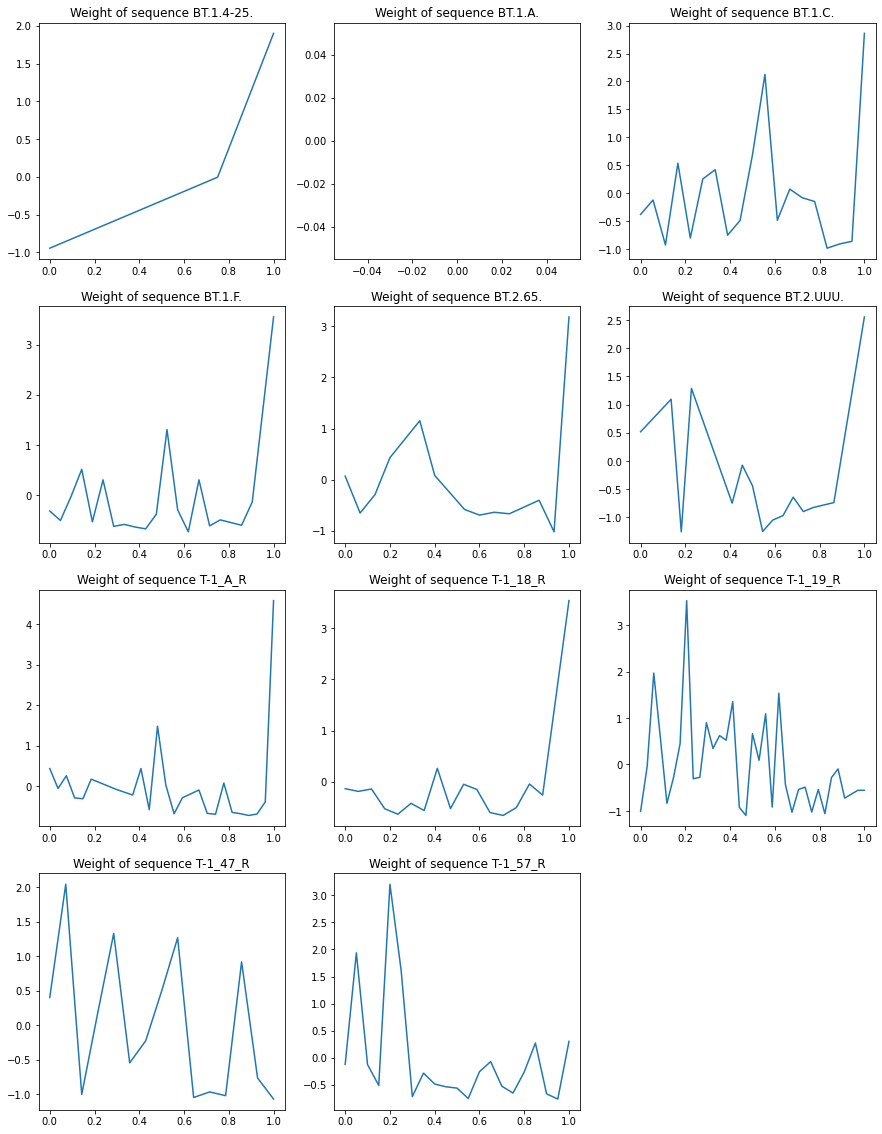

In [15]:
fig = plt.figure(figsize=(15, 20))
for index, (id, nodes_list) in enumerate(store_node_lists.items()):
    plt.subplot(4,3, index+1)
    plot_function(nodes_list, graphs, id, "weight")
    plt.title("Weight of sequence "+id)
plt.show()

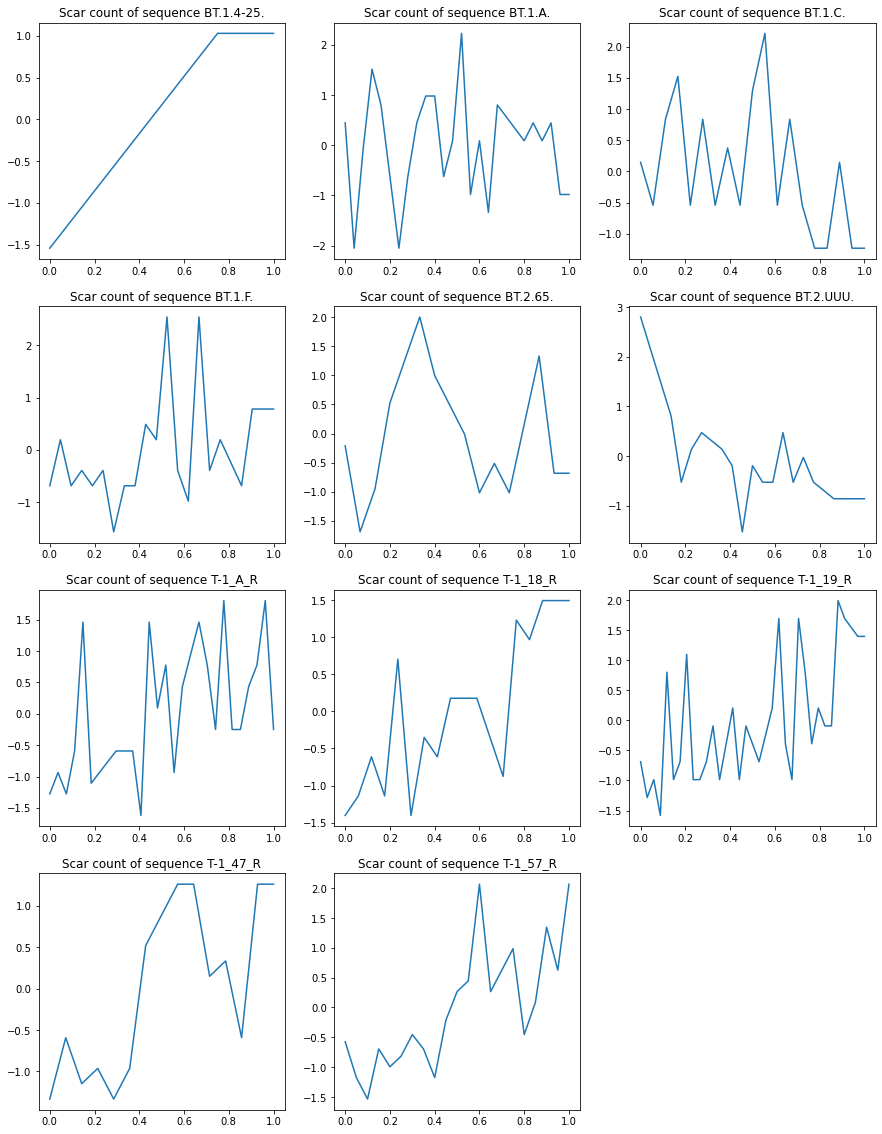

In [16]:
fig = plt.figure(figsize=(15, 20))
for index, (id, nodes_list) in enumerate(store_node_lists.items()):
    plt.subplot(4,3, index+1)
    plot_function(nodes_list, graphs, id, "scar_count")
    plt.title("Scar count of sequence "+id)
plt.show()